<a href="https://colab.research.google.com/github/mateopolancecofficial/DeepLearningProjects/blob/main/ComputerVision/ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 102kB 6.2MB/s 


## Image Classification ML pipeline
ML pipeline for image classification task. 

Steps:
  - split source data images on train and test subsets
  - create tensorflow train, validation and test datasets
  - add data augmentation step for increasing input data variability
  - create model for hyper-parameter tuning
  - fit model with best parameters
  - calculate AUC, Precision and Recall metrics for each class on test dataset

In [2]:
# set installation txt file with all relevant packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import PIL
import PIL.Image
import pathlib
import shutil
import random
import imghdr

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import kerastuner as kt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


In [3]:
#tf.debugging.set_log_device_placement(True)

if tf.config.list_physical_devices('GPU'):
  if len(tf.config.list_physical_devices('GPU')) > 1:
    strategy = tf.distribute.MirroredStrategy()
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
  else:
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    strategy = None

Num GPUs Available:  1


### Download images dataset

In [4]:
# download images folder
!wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
from shutil import unpack_archive
unpack_archive('/content/flower_photos.tgz', '/content/')
#!unzip -q name_of_zipped_dataset.zip

--2021-07-01 22:43:24--  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 74.125.142.128, 173.194.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M   102MB/s    in 2.1s    

2021-07-01 22:43:27 (102 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]



### Set global parameters

In [5]:
# load data parameters

MAX_WIDTH, MAX_HEIGHT = 100, 100
ORIGIN = os.path.dirname(os.path.abspath("ImageClassification.ipynb"))
print(ORIGIN)
SOURCE = 'flower_photos'
#test_path = ''
# available color modes are "grayscale", "rgb", "rgba", (images will be converted to have 1, 3, or 4 channels)
COLOR_MODE = "rgb"
SOURCE_PATH = os.path.join(ORIGIN, SOURCE)
#test_source_folder_path = os.path.join(ORIGIN, test_path)
print(SOURCE_PATH)

BATCH_SIZE = 32
TEST_SPLIT = 0.2
VALIDATION_SPLIT = 0.2
SEED = 100

IMAGE_EXTENSIONS = ['png', 'jpg', 'jpeg', 'tiff', 'bmp', 'gif']


/content
/content/flower_photos


### Split source dataset on train and test subsets
After splitting source dataset, train and test datasets need to be resized on the same values of height and width

In [9]:
# split dataset on test and train if is not currently

def train_test_split():
  """
  Create train and test subsets from source dataset.
  """

  source_path = os.path.join(ORIGIN, SOURCE_PATH)
  train_path = "train_data"
  test_path = "test_data"
  train_path = os.path.join(ORIGIN, train_path)
  test_path = os.path.join(ORIGIN, test_path)

  if os.path.exists(train_path):
    shutil.rmtree(train_path)
  os.mkdir(train_path)

  if os.path.exists(test_path):
    shutil.rmtree(test_path)
  os.mkdir(test_path)

  num_of_classes = len(os.listdir(source_path))

  for dir in os.listdir(source_path):
    files = os.listdir(os.path.join(source_path, dir))
    if len(files) > 0:
      # create train dataset dir
      if not os.path.exists(os.path.join(train_path, dir)):
        os.mkdir(os.path.join(train_path, dir))
      # create test dataset dir
      if not os.path.exists(os.path.join(test_path, dir)):
        os.mkdir(os.path.join(test_path, dir))
      # extract names of test subset files
      test_num = len(files) * TEST_SPLIT
      indicies = random.sample(range(len(files)), round(test_num))
      test_files_names = [files[i] for i in indicies]
      
      for f in files:
        if f in test_files_names:
          # move file from source dataset to test dataset
          image_type = imghdr.what(os.path.join(os.path.join(source_path, dir), f))
          if image_type in IMAGE_EXTENSIONS:
            os.replace(os.path.join(os.path.join(source_path, dir), f), 
                       os.path.join(os.path.join(test_path, dir), f))
        
        else:
          # move file from source dataset to test dataset
          image_type = imghdr.what(os.path.join(os.path.join(source_path, dir), f))
          if image_type in IMAGE_EXTENSIONS:
            os.replace(os.path.join(os.path.join(source_path, dir), f), 
                       os.path.join(os.path.join(train_path, dir), f))
      
      

  return train_path, test_path, num_of_classes


In [10]:
def get_min_img_size(train_path, test_path=None):
  """
  Check if all images are of the same size and get min image width and min image
  height.
  param train_path:              path of a train source folder
  param test_path:               path of a test source folder
  return img_width, img_height:  min image width and height scalar values
  """

  img_width_list = []
  img_height_list = []

  def get_image_params(data_path):
    img_width, img_height = None, None
    dirs = os.listdir(data_path)
    for dir in dirs:
      files = os.listdir(data_path + "/" + dir)
      for f in files:
        image_path = data_path + "/" + dir + "/" + f
        image = tf.keras.preprocessing.image.load_img(image_path)
        image = keras.preprocessing.image.img_to_array(image)
        if img_width == None:
          img_width, img_height = image.shape[0], image.shape[1]
        else:
          if image.shape[0] < img_width:
            img_width = image.shape[0]
          if image.shape[1] < img_height:
            img_height = image.shape[1]

    return img_width, img_height

  if test_path == None:
    return get_image_params(train_path)
    
  else:
    img_width_train, img_height_train = get_image_params(train_path)
    img_width_list.append(img_width_train)
    img_height_list.append(img_height_train)

    img_width_test, img_height_test = get_image_params(test_path)
    img_width_list.append(img_width_test)
    img_height_list.append(img_height_test)
  
    return min(img_width_list), min(img_height_list)

In [12]:
def set_resize_image_parameters(img_width, img_height):
  """
  Set parameters for resizing input images.
  param img_width, img_height:   image height and image with scalar values
  return img_width, img_height:  resized image height and image with scalar values     
  """

  if img_width > MAX_WIDTH:
    img_width = MAX_WIDTH

  if img_height > MAX_HEIGHT:
    img_height = MAX_HEIGHT
  
  return img_height, img_width



In [13]:
# set tensorflow dataset parameters
# remove unneccessary files from source directory
train_path, test_path, num_of_classes = train_test_split()
img_width, img_height = get_min_img_size(train_path, test_path=test_path)
img_width, img_height = set_resize_image_parameters(img_height, img_width)
image_size = (img_width, img_height)
print(image_size)

(100, 100)


### Create tensorflow batched datasets
Check does train, validation and test datasets has the same number of label classes.

In [14]:
def get_image_dataset(data_path, image_size, num_of_classes, subset = None):
  """
  Create tensorflow dataset from data directory object.
  param data_path:        string, source folder path
  param image_size:       touple (image_with, image_height)
  param subset:           optional, name of subset ('train', 'validation')
  return dataset:         dict, tensorflow dataset and class names
  """
    
  if subset:
    validation_split = VALIDATION_SPLIT
    seed = SEED
  
  else:
    validation_split = None
    seed = None

  dataset = tf.keras.preprocessing.image_dataset_from_directory(
      data_path,
      color_mode=COLOR_MODE,
      image_size=image_size,
      batch_size=BATCH_SIZE,
      seed=seed,
      validation_split=validation_split, 
      subset=subset
    )
    
  dataset.class_names.sort()
  class_names = dataset.class_names
    
  return {
      "data": dataset,
      "classNames": class_names
        }

In [33]:
# split train dataset on train and validation datasets
# load train dataset to tensorflow dataset
training_ds = get_image_dataset(
    train_path,
    image_size,
    num_of_classes,
    subset = "training"
)

# load validation dataset to tensorflow dataset
validation_ds = get_image_dataset(
    train_path,
    image_size,
    num_of_classes,
    subset = "validation"
)

# load test dataset to tensorflow dataset
test_ds = get_image_dataset(
    test_path,
    image_size,
    num_of_classes
)


Found 2935 files belonging to 5 classes.
Using 2348 files for training.
Found 2935 files belonging to 5 classes.
Using 587 files for validation.
Found 735 files belonging to 5 classes.


In [34]:
len(training_ds)

2

In [16]:
def check_data(training_ds, validation_ds, test_ds):

  # check does training and validation datasets contains same classes
  validation_check = training_ds["classNames"] == validation_ds["classNames"]
  assert_fail_message = "Training and Validation classes should match. "
  assert(validation_check), assert_fail_message

  # check does training and test datasets contains same classes
  test_check = training_ds["classNames"] == test_ds["classNames"]
  assert_fail_message = "Training and Test classes should match. "
  assert(test_check), assert_fail_message

  class_names = training_ds["classNames"]
  number_classes = len(class_names)
  print(training_ds["classNames"])
  print(validation_ds["classNames"])
  print(test_ds["classNames"])

  return class_names

In [17]:
class_names = check_data(training_ds, validation_ds, test_ds)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [18]:
def visualize_dataset(dataset):
  """
  Visualize input images.
  param dataset: tensorflow dataset objects
  """

  image_shape = []
  plt.figure(figsize=(10, 10))
  
  # take first batch (batch_size = num_of_images = num_of_labels)
  # labels are label encoded
  # images are unscaled (0 - 255) 4D tensors (batch_size, width, height, chanells)
  for images, labels in dataset.take(1):
    # take first 9 images and labels from first batch
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")
  
  for image_batch, labels_batch in dataset.take(1):
    image_shape = [image_batch.shape[1], image_batch.shape[1], 
                   image_batch.shape[2], image_batch.shape[3]]
    print("Image batch shape is {}".format(image_batch.shape))
    print("Label batch shape is {}".format(labels_batch.shape))
    break
  
  return image_shape

Image batch shape is (32, 100, 100, 3)
Label batch shape is (32,)


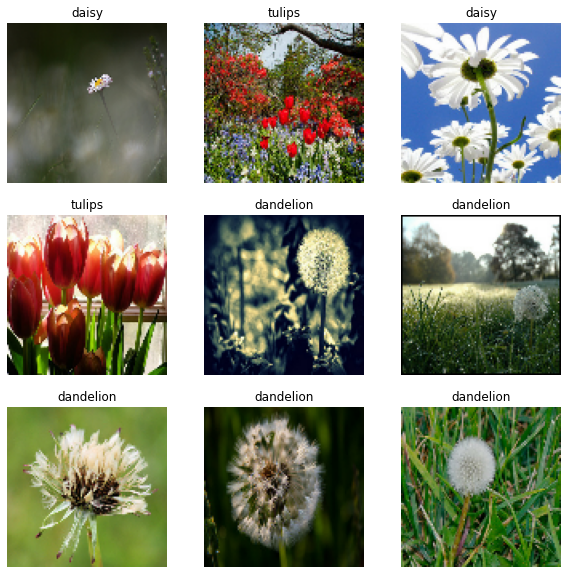

In [19]:
image_shape = visualize_dataset(training_ds['data'])

### Add data augmentation on input datasets
On train and validation datasets RandomFlip, RandomRotation, RandomContrast and RandomZoom functions will be applied.

For all three datasets rescaling will be applied on all images to range [0, 1] and labels will be on-hot encoded.

In [25]:
def data_augmentation(dataset, image_size):
  """
  Add variability in input dataset. Normalize image data. Hot-encode label variable.
  param dataset: tensorflow dataset
  return dataset: augmented input dataset
  """

  def label_preprocess(image, label):
    label = tf.one_hot(label, num_of_classes)
    return image, label
  
  def brightness(img, label):
     img = tf.image.adjust_brightness(img, 0.1)
     return img, label
 
  def gamma(img, label):
     img = tf.image.adjust_gamma(img, 0.1)
     return img, label

  def hue(img, label):
     img = tf.image.adjust_hue(img, -0.1)
     return img, label

  def crop(img, label):
     img = tf.image.central_crop(img, 0.7)
     img = tf.image.resize(img, (image_size[0], image_size[1]))
     return img, label

  random_flip_layer = layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")
  random_rotation_layer = layers.experimental.preprocessing.RandomRotation(0.3)
  random_contrast_layer = tf.keras.layers.experimental.preprocessing.RandomContrast(0.3)
  random_zoom_layer = tf.keras.layers.experimental.preprocessing.RandomZoom(
      height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2))
  normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
  
  a = dataset.map(lambda x, y: (random_flip_layer(x), y))
  b = dataset.map(lambda x, y: (random_rotation_layer(x), y))
  c = dataset.map(lambda x, y: (random_contrast_layer(x), y))
  d = dataset.map(lambda x, y: (random_zoom_layer(x), y))
  e = dataset.map(lambda x, y: (normalization_layer(x), y))

  f = dataset.map(brightness)
  g = dataset.map(gamma)
  h = dataset.map(hue)
  i = dataset.map(crop)

  dataset = dataset.concatenate(a)
  dataset = dataset.concatenate(b)
  dataset = dataset.concatenate(c)
  dataset = dataset.concatenate(d)
  dataset = dataset.concatenate(e)
  dataset = dataset.concatenate(f)
  dataset = dataset.concatenate(g)
  dataset = dataset.concatenate(h)
  dataset = dataset.concatenate(i)

  # one hot-encode label !
  dataset = dataset.map(label_preprocess)

  return dataset

In [26]:
def preprocess_test_data(dataset):
  """
  Normalize image data. Hot-encode label variable.
  param dataset: tensorflow dataset
  return dataset: augmented input dataset
  """

  def label_preprocess(image, label):
    label = tf.one_hot(label, num_of_classes)
    return image, label

  normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
  dataset = dataset.map(lambda x, y: (normalization_layer(x), y))

  dataset = dataset.map(label_preprocess)

  return dataset



In [28]:

AUTOTUNE = tf.data.AUTOTUNE

#train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
train_dataset = data_augmentation(training_ds['data'], image_size)
#train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
#train_dataset = train_dataset.batch(batch_size=BATCH_SIZE, drop_remainder=True)

val_dataset = preprocess_test_data(validation_ds['data'])
#val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
#val_dataset = val_dataset.batch(batch_size=BATCH_SIZE, drop_remainder=True)

#test_dataset = test_ds['data'].map(input_preprocess)
test_dataset = preprocess_test_data(test_ds['data'])
#test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)
#test_dataset = test_dataset.batch(batch_size=BATCH_SIZE, drop_remainder=True)


In [29]:
print("Num of batches in training dataset: {}".format(len(list(train_dataset))))
print("Num of batches in validation dataset: {}".format(len(list(val_dataset))))
print("Num of batches in test dataset: {}".format(len(list(test_dataset))))

Num of batches in training dataset: 740
Num of batches in validation dataset: 190
Num of batches in test dataset: 23


In [37]:
print("Num of batches in training dataset: {}".format(len(list(training_ds['data']))))


Num of batches in training dataset: 74


### Create model
CNN model:
  - Vanishing gradient problem - add residual connections and batch normalization layers
  - Overfitting - add regularization and dropout layers
  - prepare model for hyperparameter tuning
  - add final dense layer with num_of_classes number of neurons with 'softmax' activation function
  - use CategoricalCrossentropy loss function
  - use AUC metric to calculate validation score (averaged across labels)

In [ ]:
def create_model(hp):
  """
  Create and compile model. Use keras functional API.
  """

  # define hyper-parameters for tuning
  hp_units = hp.Int('hp_units', min_value=128, max_value=256, step=32)

  inputs = keras.Input(shape=(image_shape[2], image_shape[1], image_shape[3]), 
                      name="input_img")
    
  x = layers.Conv2D(32, 3, activation="relu")(inputs)
  x = layers.Conv2D(64, 3, activation="relu")(x)
  block_1_output = layers.MaxPooling2D()(x)

  x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
  x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
  block_2_output = layers.add([x, block_1_output])
  normalized_1 = layers.BatchNormalization()(block_2_output)

  x = layers.Conv2D(64, 3, activation="relu", padding="same")(normalized_1)
  x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
  block_3_output = layers.add([x, normalized_1])
  normalized_2 = layers.BatchNormalization()(block_3_output)

  x = layers.Conv2D(128, 3, activation="relu")(normalized_2)
  x = layers.MaxPooling2D()(x)

  x = layers.Flatten()(x)

  x = layers.Dense(units=hp_units, activation="relu")(x)
  x = layers.Dropout(rate=hp.Float(
                    'dropout_1',
                    min_value=0.1,
                    max_value=0.5,
                    default=0.25,
                    step=0.1,
                    ))(x)

  outputs = layers.Dense(num_of_classes, activation='softmax',
                         kernel_regularizer=tf.keras.regularizers.L2(1e-4),
                         bias_regularizer=tf.keras.regularizers.L2(1e-4))(x)

  model = keras.Model(inputs, outputs, name="image_classifier")

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[auc_score])

  return model

### Set hyper-parameter optimizer
During hyper-parameter optimization process track AUC validation score in max direction (AUC is increasing during training).

In [ ]:
def set_hyperparameter_optimizer(strategy):
  """
  Set hyperparameter optimizer.
  """
  #objective=kt.Objective("auc_score", direction="min"),
  tuner = kt.Hyperband(
        hypermodel=create_model,
        objective=kt.Objective("val_auc_score", direction="max"),
        max_epochs=8,
        factor=2,
        hyperband_iterations=3,
        distribution_strategy=strategy,
        directory='results_dir',
        project_name='image_classification')

  return tuner


In [ ]:
num_of_classes = len(class_names)
auc_score = tf.keras.metrics.AUC(from_logits=False, multi_label=True,
              num_labels=num_of_classes, name='auc_score')
tuner = set_hyperparameter_optimizer(strategy)

INFO:tensorflow:Reloading Oracle from existing project results_dir/image_classification/oracle.json


In [ ]:
# define early stop callback to prevent overfitting
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_auc_score', patience=10, mode='max')

In [ ]:
tuner.search(train_dataset,
             validation_data=val_dataset,
             epochs=5,
             callbacks=[stop_early])

# get optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 108 Complete [00h 09m 20s]
val_auc_score: 0.8845731616020203

Best val_auc_score So Far: 0.8952945470809937
Total elapsed time: 05h 37m 32s
INFO:tensorflow:Oracle triggered exit


### Train model with best hyper-parameters

In [ ]:
model = tuner.hypermodel.build(best_hps)

In [ ]:
# checkpoints callback is not defined because a lack of disk space on Google Colab
# define early stop callback to prevent overfitting
#stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_auc_score', patience=10,
#                                              mode='max')
epochs = 20
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=epochs,
                    callbacks=[stop_early]
                    )

Epoch 1/20
222/222 [==============================] - 46s 206ms/step - loss: 0.6042 - auc_score: 0.9487 - val_loss: 0.9037 - val_auc_score: 0.9171
Epoch 2/20
222/222 [==============================] - 46s 204ms/step - loss: 0.5978 - auc_score: 0.9489 - val_loss: 0.8777 - val_auc_score: 0.9145
Epoch 3/20
222/222 [==============================] - 46s 205ms/step - loss: 0.5778 - auc_score: 0.9519 - val_loss: 0.8890 - val_auc_score: 0.9145
Epoch 4/20
222/222 [==============================] - 47s 210ms/step - loss: 0.5748 - auc_score: 0.9520 - val_loss: 0.9181 - val_auc_score: 0.9156
Epoch 5/20
222/222 [==============================] - 46s 205ms/step - loss: 0.5676 - auc_score: 0.9534 - val_loss: 0.8535 - val_auc_score: 0.9191
Epoch 6/20
222/222 [==============================] - 46s 204ms/step - loss: 0.5483 - auc_score: 0.9564 - val_loss: 0.9728 - val_auc_score: 0.9116
Epoch 7/20
222/222 [==============================] - 45s 199ms/step - loss: 0.5383 - auc_score: 0.9574 - val_loss: 0.

### Plot training results 

In [ ]:
def plot_training_results(history, epochs):

  acc = history.history['auc_score']
  val_acc = history.history['val_auc_score']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training AUC')
  plt.plot(epochs_range, val_acc, label='Validation AUC')
  plt.legend(loc='lower right')
  plt.title('Training and Validation AUC')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

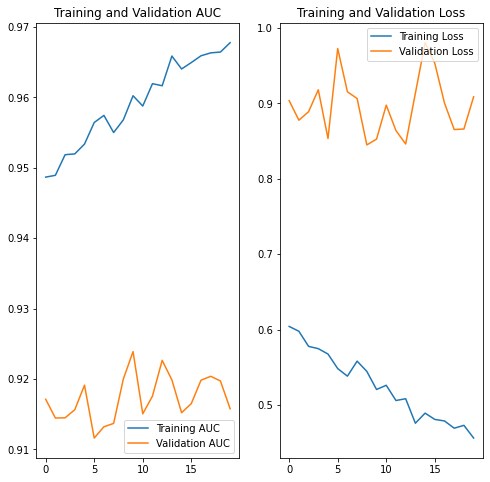

In [ ]:
epochs = len(history.history['loss'])
plot_training_results(history, epochs)

### Calculate AUC, Precision and Recall scores on test dataset

In [ ]:
predictions = model.predict(test_dataset)

In [ ]:
predictions

array([[2.2848256e-02, 9.6375960e-01, 1.3384465e-02, 3.7229603e-12,
        7.6889983e-06],
       [4.8528076e-04, 9.9645162e-01, 5.8589905e-04, 7.5000068e-09,
        2.4772615e-03],
       [1.4981787e-10, 5.1744231e-03, 2.8524090e-09, 9.9480861e-01,
        1.7015109e-05],
       ...,
       [6.2538224e-06, 6.3266000e-04, 9.3324654e-02, 3.5666995e-02,
        8.7036937e-01],
       [1.4160590e-09, 2.9334088e-04, 3.0503104e-05, 9.9868006e-01,
        9.9611271e-04],
       [3.2225263e-14, 1.6641858e-05, 8.5456253e-11, 9.9997628e-01,
        6.9811945e-06]], dtype=float32)

In [ ]:
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

In [ ]:
def calculate_auc(y_true, predictions):
  
  m = tf.keras.metrics.AUC(from_logits=False, multi_label=True,
              num_labels=num_of_classes)

  m.update_state(y_true, predictions)

  return m.result().numpy()

In [ ]:
auc_test_score = calculate_auc(y_true, predictions)
auc_test_score

0.49566096

In [ ]:
def calculate_precision(y_true, predictions):

  precision_scores = []

  for i in range(num_of_classes):
    m = tf.keras.metrics.Precision(thresholds=0.5, class_id=i)
    m.update_state(y_true, predictions)
    precision_scores.append(m.result().numpy())

  return sum(precision_scores) / len(precision_scores)

In [ ]:
precision_test_score = calculate_precision(y_true, predictions)
precision_test_score

0.17802924513816834

In [ ]:
def calculate_recall(y_true, predictions):

  recall_scores = []

  for i in range(num_of_classes):
    m = tf.keras.metrics.Recall(thresholds=0.5, class_id=i)
    m.update_state(y_true, predictions)
    recall_scores.append(m.result().numpy())

  return sum(recall_scores) / len(recall_scores)

In [ ]:
recall_test_score = calculate_recall(y_true, predictions)
recall_test_score

0.15079705119132997